In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve,auc
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

In [2]:
df = pd.read_csv('../Desktop/train.csv')
df.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [3]:
df = df.drop('id',axis = 'columns')

In [4]:
print(f'The shape of the data is {df.shape}')

The shape of the data is (31962, 2)


In [5]:
df = df.drop_duplicates(keep='first')

In [6]:
print(f'After checking for duplicates: The shape of the data is {df.shape}')

After checking for duplicates: The shape of the data is (29530, 2)


In [7]:
print(f'Checking for null values in data....... \n{df.isnull().any()}')

Checking for null values in data....... 
label    False
tweet    False
dtype: bool


In [8]:

pos = 100*len(df.loc[df['label']==0,'label'])/len(df['label'])
neg = 100*len(df.loc[df['label']==1,'label'])/len(df['label'])
print(f'Percentage of Negative Sentiment tweets is {pos}')
print(f'Percentage of Postitive Sentiment tweets is {neg}')

Percentage of Negative Sentiment tweets is 93.18320352184219
Percentage of Postitive Sentiment tweets is 6.816796478157806


In [9]:
stop_words = stopwords.words('english')

In [10]:
Word = WordNetLemmatizer()


In [11]:
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result) # greater than sign
    result = re.sub('&#x27;', "'", result) # apostrophe
    result = re.sub('&quot;', '"', result) 
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result) # paragraph tag
    result = re.sub('<i>', ' ', result) #italics tag
    result = re.sub('</i>', '', result) 
    result = re.sub('&#62;', '', result)
    result = re.sub("\n", '', result) # newline 
    return result

In [12]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [13]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

In [14]:
def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [15]:
def stop_words_remove(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [16]:
def remove_word_user(df):    
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x != 'user'))

In [17]:
def spell_correction(df):
    df['tweet'].apply(lambda x: str(TextBlob(x).correct()))

In [18]:
def lemmatize(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))

In [19]:
def cleaning(df):
    df['tweet'] = df['tweet'].apply(clean)
    df['tweet'] = df['tweet'].apply(deEmojify)
    df['tweet'] = df['tweet'].apply(lambda x: remove_punct(x))
    lower_case(df)
    stop_words_remove(df)
    remove_word_user(df)
    lemmatize(df)

In [20]:
cleaning(df)

In [21]:
X = df.drop('label', axis = 'columns')
y = df['label']

In [22]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ROC-AUC score: \n {roc_auc_score(y_train,pred)}\n")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ROC-AUC score: \n {roc_auc_score(y_test,pred)}\n")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [23]:
vector = CountVectorizer(stop_words= "english",max_features=3000, ngram_range = (1,2))

trans = vector.fit(X['tweet'])
x = trans.transform(X['tweet'])
X = X.drop('tweet',axis = 'columns')
X = pd.concat([X.reset_index(drop = True),pd.DataFrame(x.todense()).reset_index(drop = True)],axis = 'columns')
X = X.fillna(0)

In [24]:
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over',over),('under', under)]
pipeline = PL(steps=steps)

X, y = pipeline.fit_resample(X, y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 40, test_size = 0.35,stratify=y)

In [26]:
tfidf = TfidfTransformer()
model = RandomForestClassifier()

In [27]:
pipeline2 = Pipeline([
    ('tfidf', tfidf),
    ('model', model),
    ])
model_final = pipeline2.fit(X_train,y_train)
preds = model_final.predict(X_test)

Train Result:
Accuracy Score: 98.15%
_______________________________________________
ROC-AUC score: 
 0.9845532309500723

_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.996856     0.952572  0.981455      0.974714      0.982094
recall         0.975257     0.993850  0.981455      0.984553      0.981455
f1-score       0.985938     0.972773  0.981455      0.979356      0.981550
support    14307.000000  7154.000000  0.981455  21461.000000  21461.000000
_______________________________________________
Confusion Matrix: 
 [[13953   354]
 [   44  7110]]


_______________________________________________

Test Result:
Accuracy Score: 92.24%
_______________________________________________
ROC-AUC score: 
 0.9210199173440665

_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.

<Axes: >

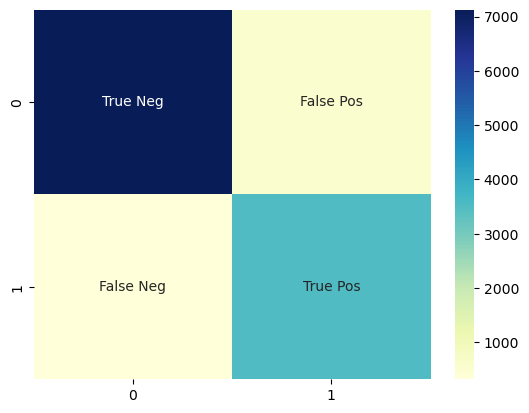

In [28]:
print_score(pipeline2, X_train, y_train, X_test, y_test, train=True)
print("\n_______________________________________________\n")
print_score(pipeline2, X_train, y_train, X_test, y_test, train=False)
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(y_test, pipeline2.predict(X_test)),annot = labels,fmt='',cmap = 'YlGnBu')